In [11]:

import os
import sys
src_path = sys.path[0].replace("paper_working", "src")
# data_path = sys.path[0].replace("notebooks", "data")
if src_path not in sys.path:
    sys.path.append(src_path)

out_path = sys.path[0].replace("paper_working", "output")

import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
import pandas as pd
import sys
import calendar
import os
from matplotlib.lines import Line2D
import matplotlib.dates as mdates


from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import ConnectionPatch

rc_={
    "figure.dpi":600,
    "font.size":10,
    "axes.facecolor":"none",
    "savefig.facecolor":"white",
    "text.usetex":False,
    "legend.frameon":False,
    'legend.fontsize': 10,
    'axes.labelsize': 9,
         'axes.titlesize':12,
         'xtick.labelsize':12,
         'ytick.labelsize':12
}
plt.rcParams.update(rc_)



legend_fs=10
label_fs=12
ticklabel_fs=9
from plot_helper import *

from utils.plot_utils import *
customize_plt() # customize plt configs, see plot_utils

In [12]:
def pre_process(df,duration_key='month_of_year',key='OPEX'):
    df['label']=df['method']+'-'+df['pred_method']+'-'+df['p_grid_max_method']
    print(df.label.unique())
    df=df.reset_index()
    grouped_df=df.groupby(by=duration_key)
    to_concat=[]
    for group in grouped_df.groups.keys():
        df_temp=grouped_df.get_group(group)
        try:
            upper=df_temp[df_temp.label=='RBC-GT-by_execution'][key].values[0]
            lower=df_temp[df_temp.label=='MPC-GT-by_execution'][key].values[0]
        except:
            upper=df_temp[df_temp.label=='RBC-GT-by_execution'][key]
            lower=df_temp[df_temp.label=='MPC-GT-by_execution'][key]
        
        upper=np.nanmean(upper)
        lower=np.nanmean(lower)
        diff=upper-lower
        new_key='relative_'+key
        df_temp[new_key]=None
        for i in df_temp.index:
            df_temp.loc[i,new_key]=-(df_temp.loc[i,key]-lower)/diff*100+100
        to_concat.append(df_temp)

    return pd.concat(to_concat)

In [13]:
log_fn = r"L:\Coding_project\Energy_grid_new\output\experiments\Multiple_model_compare\DeepAR_optuna.xlsx"
log_df = pd.read_excel(log_fn, index_col=0)
exp_name = r"Multiple_model_compare"
exp_folder=r"L:\Coding_project\Energy_grid_new_exp_local"
log_df


,run_bat_as_sol,ev_charge_rule_default,shift,pv_to_bld,price_dc,B_kWh,status,bld,pv,ev,...,bat_e_terminal,bat_e_terminal_revenue,load_bld_error_max_neg,load_bld_error_max_pos,load_pv_error_max_neg,load_pv_error_max_pos,load_ev_error_max_neg,load_ev_error_max_pos,load_net_error_max_neg,load_net_error_max_pos
id,,,,,,,,,,,,,,,,,,,,,
1,True,unif,False,0.5,0.6,441.6,D,Sum,Sum,ALL,...,0.000000e+00,0.000000e+00,-59.984790,19.898339,0,0,-141.580952,126.361663,-179.289094,117.281566
2,True,unif,False,0.5,0.6,441.6,D,Sum,Sum,ALL,...,3.552714e-15,2.152073e-17,-32.653030,11.825655,0,0,-94.242177,165.000780,-100.971725,161.382480
3,True,unif,False,0.5,0.6,441.6,D,Sum,Sum,ALL,...,0.000000e+00,0.000000e+00,-45.790728,20.899343,0,0,-139.744596,146.097026,-138.713827,136.846450
4,True,unif,False,0.5,0.6,441.6,D,Sum,Sum,ALL,...,0.000000e+00,0.000000e+00,-45.739750,11.334375,0,0,-113.606255,139.299199,-158.881208,138.789584
5,True,unif,False,0.5,0.6,441.6,D,Sum,Sum,ALL,...,0.000000e+00,0.000000e+00,-21.141136,42.107350,0,0,-133.397960,162.078737,-131.707876,164.116184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,True,unif,False,0.5,0.0,441.6,D,Sum,Sum,ALL,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
189,True,unif,False,0.5,0.0,441.6,D,Sum,Sum,ALL,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
190,True,unif,False,0.5,0.0,441.6,D,Sum,Sum,ALL,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000


In [14]:
def get_trial_res(idx_mpc, idx_gt):
    mpc_fn = log_df.loc[idx_mpc, "save_fn"]
    gt_fn  = log_df.loc[idx_gt, "save_fn"]
    mpc_df = pd.read_excel(os.path.join(exp_folder, exp_name, mpc_fn), sheet_name=None, index_col=0)
    gt_df = pd.read_excel(os.path.join(exp_folder, exp_name, gt_fn), sheet_name="op_log", index_col=0)
    return mpc_df, gt_df

In [15]:

keys = ["load_pv", "load_bld", "bat_p", "ev_p", "p_grid", "latest_p_grid_max", "tou_import"]
colors = {"load_pv":"rebeccapurple","load_bld":"chocolate","p_grid":"royalblue",
          "bat_p":"darkgreen","ev_p":"darkorange","cost":"firebrick",
        "gg":"seagreen", "gge":"seagreen", "pp":"royalblue", "nn":"plum","tou_import":'sandybrown',
          "msc":"firebrick", "tou":"sandybrown", "latest_p_grid_max":"orangered"}
names = {"load_pv":"PV","load_bld":"Building","p_grid":"Grid",
          "bat_p":"Battery","ev_p":"EV","cost":"Cost","tou_import":'TOU-Price',
        "gg":"MPC-GG", "gge":"MPC-GGE", "pp":"MPC-PP", "nn":"MPC-NN",
          "msc":"MSC", "tou":"TOU", "latest_p_grid_max":"Grid-max"}

def draw_load_curve(mpc_df, gt_df, key, t0=datetime(2019,5,1,0,0), pred_t=0, gif=False, ax=None):

    ax = plt.gca() if ax is None else ax

    K, delta, exe_K = 96, 0.25, 4

    ts = pd.date_range(t0, t0+timedelta(hours=24), freq=f"{delta}H", inclusive="left")
    ts_exe = pd.date_range(t0, t0+timedelta(hours=24), freq=f"{delta*exe_K}H", inclusive="left")

    y_gt = gt_df.loc[ts, key].values
    
    if key in ["load_bld", "load_pv"]:
        y_mpc = mpc_df[f"pred_{key}"].loc[ts_exe, range(exe_K)].values.reshape(-1,)
    else:
        y_mpc = mpc_df["op_log"].loc[ts, key].values

    if key != 'latest_p_grid_max' :
        if key=='tou_import':
            y_pred=None
        else:
            y_pred = mpc_df[f"pred_{key}"].loc[
        t0+timedelta(hours=pred_t), range(K - int(pred_t/delta))].values
    # since the latest_p_grid_max_pred is not implemented previously
    # cal them here
    else:
        y_pred_tmp=mpc_df[f"pred_p_grid"].loc[
        t0+timedelta(hours=pred_t), range(K - int(pred_t/delta))].values
        max=y_pred_tmp[0]
        for i in range(len(y_pred_tmp)):
            if y_pred_tmp[i]>=max:
                max=y_pred_tmp[i]
            y_pred_tmp[i]=max
        y_pred=y_pred_tmp
        
    # if key == "load_pv":
    #     y_gt *= -1
    #     y_mpc *= -1
    #     y_pred *= -1

    x = np.arange(0, K*delta, delta)
    x_pred = np.arange(pred_t, K*delta, delta)

    c = colors[key]

    
    if gif:
        exe_steps = int(pred_t/delta)+1
        ax.fill_between(x[:exe_steps], y_gt[:exe_steps], y_mpc[:exe_steps], color=c, alpha=0.2, edgecolor="none", zorder=200)
        #if key != 'latest_p_grid_max':
        ax.fill_between(x_pred, y_gt[exe_steps-1:], y_pred, color=c, alpha=0.6, edgecolor="none", zorder=200)
        ax.plot(x[:exe_steps], y_mpc[:exe_steps], color=c)
        #if key != 'latest_p_grid_max':
        ax.plot(x_pred, y_pred, color=c, alpha=0.8, lw=1.5, ls="dashed", zorder=-100)
        
    else:
        ax.fill_between(x, y_gt, y_mpc, color=colors[key], edgecolor="none", alpha=0.3, zorder=-200)
        ax.plot(x, y_mpc, c=colors[key])
        if key != 'tou_import':
            #ax.plot(x_pred, y_pred, color=colors[key], lw=1, ls="dashed", zorder=-100)
            ...
            
def draw_load_curve_grid_max(mpc_df, gt_df, key, t0=datetime(2019,5,1,0,0), pred_t=0, gif=False, ax=None):

    ax = plt.gca() if ax is None else ax

    K, delta, exe_K = 96*30, 0.25, 4

    ts = pd.date_range(t0, t0+timedelta(hours=24*30), freq=f"{delta}H", inclusive="left")
    ts_exe = pd.date_range(t0, t0+timedelta(hours=24*30), freq=f"{delta*exe_K}H", inclusive="left")

    y_gt = gt_df["op_log"].loc[ts, key].values
    

    y_mpc = mpc_df["op_log"].loc[ts, key].values


    x = np.arange(0, K*delta, delta)
    x_pred = np.arange(pred_t, K*delta, delta)

    c = colors[key]



    ax.fill_between(ts, y_gt, y_mpc, color=colors[key], edgecolor="none", alpha=0.3, zorder=-200)
    ax.plot(ts, y_mpc, c=colors[key])

            
def text_with_ratio(text, x_ratio, y_ratio, ax, **kw):
    x_lo, x_hi = ax.get_xlim()
    y_lo, y_hi = ax.get_ylim()
    x = x_lo + x_ratio * (x_hi - x_lo)
    y = y_lo + y_ratio * (y_hi - y_lo)
    ax.text(x, y, text, **kw)

In [16]:
deepar_0dc_df, gt_0dc_df = get_trial_res(41,185)#161
gt_0dc_df_grid_max, gt_0dc_df = get_trial_res(185,185)#161

C:\Users\Lunlo\AppData\Local\Temp\ipykernel_16896\2604576422.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label']=df['method']+'-'+df['pred_method']+'-'+df['p_grid_max_method']
C:\Users\Lunlo\AppData\Local\Temp\ipykernel_16896\2604576422.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[new_key]=None
C:\Users\Lunlo\AppData\Local\Temp\ipykernel_16896\2604576422.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

['MPC-DeepAR_optuna-by_execution' 'RBC-GT-by_execution'
 'MPC-GT-by_execution' 'MPC-Simple-by_execution'
 'MPC-LR_NAIVE-by_execution' 'MPC-LR_PCo-by_execution'
 'MPC-TFT_optuna-by_execution' 'MPC-XGB-by_execution']
['MPC-DeepAR_optuna-by_execution' 'RBC-GT-by_execution'
 'MPC-GT-by_execution' 'MPC-Simple-by_execution'
 'MPC-LR_NAIVE-by_execution' 'MPC-LR_PCo-by_execution'
 'MPC-TFT_optuna-by_execution' 'MPC-XGB-by_execution']


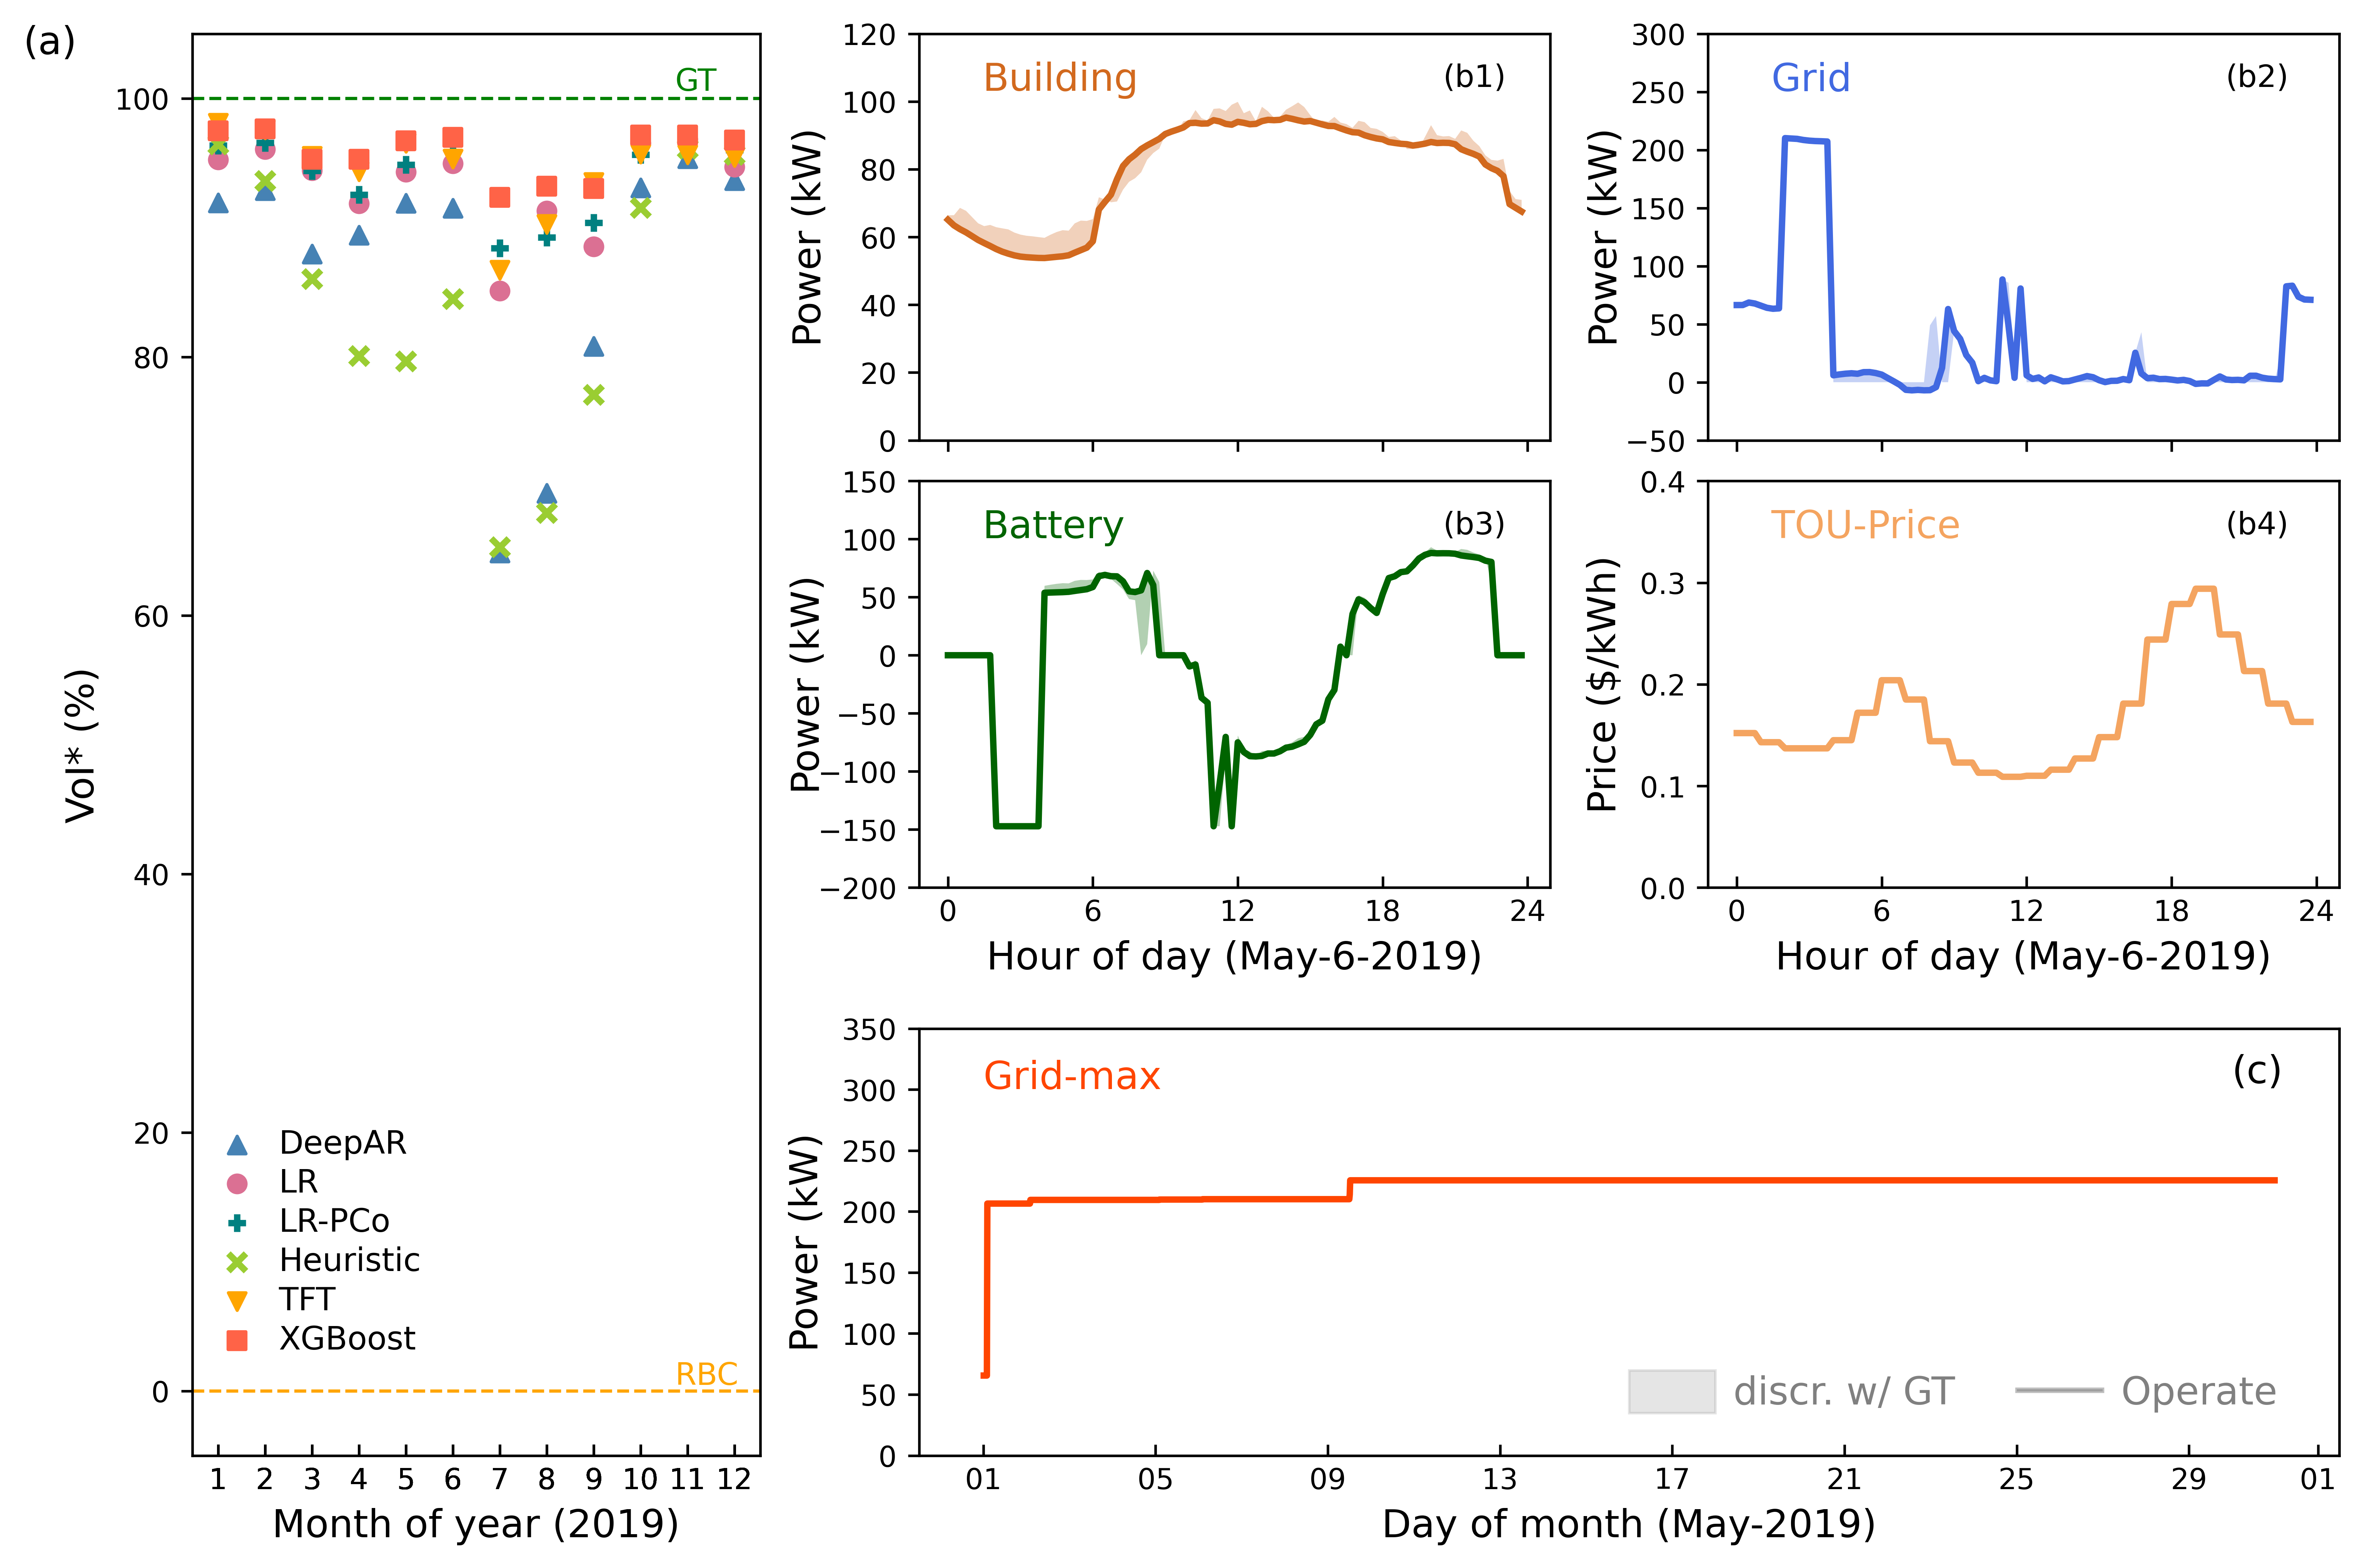

In [17]:
import matplotlib.gridspec as gridspec  # 用网格来创建子图
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.transforms as transforms

legend_fs=10
label_fs=12
ticklabel_fs=9
title_fs=14

fig = plt.figure(figsize=(12, 8))  # 创建画布
grid = gridspec.GridSpec(2, 2,width_ratios=[0.6,1.5],height_ratios=[2,1])  # 设定2行*3列的网格
grid.update(wspace =0.16, hspace = 0.22)

grid01=gridspec.GridSpecFromSubplotSpec(2,2,subplot_spec=grid[0,1],height_ratios=[1,1],width_ratios=[1,1],wspace=0.25,hspace=0.1)
#grid01.update(wspace =0.1, hspace = 0.18)

ax2 = fig.add_subplot(grid01[0, 0])  #
ax3 = fig.add_subplot(grid01[0, 1])  # 
ax4 = fig.add_subplot(grid01[1, 0])  # 
ax5 = fig.add_subplot(grid01[1, 1])  # 

ax6 = fig.add_subplot(grid[1, 1])  # 

ax1 = fig.add_subplot(grid[0:2,0])  #

'''ax1.text(-1.6,115,'(a)')
ax2.text(-2.1,17.7,'(c)')
ax3.text(-2.3,493,'(d)')
ax1.text(-1.6,-135,'(b)')
'''
label_loc=[0.75,0.92]
t0=pd.Timestamp(2019,5,6,0,0)
keys=['load_bld','p_grid','bat_p','tou_import']
axs=[ax2,ax3,ax4,ax5]
i=0
for key in keys:
    ax=axs[i]
    draw_load_curve(deepar_0dc_df, gt_0dc_df,key,ax=ax,t0=t0)
    ax.text(0.1,0.86,names[key],color=colors[key],fontsize=label_fs,
            transform=transforms.blended_transform_factory(
                ax.transAxes, ax.transAxes))
    i+=1
off=1.05
offy=-0.08
trans=transforms.blended_transform_factory(ax2.transAxes, ax2.transAxes)
ax2.text(-0.22+off,0.95+offy,'(b1)',color='black',fontsize=label_fs*0.8,transform=trans,zorder=200)
ax2.text(1.02+off,0.95+offy,'(b2)',color='black',fontsize=label_fs*0.8,transform=trans,zorder=200)
ax2.text(-1.42,0.95,'(a)',color='black',fontsize=label_fs,transform=trans,zorder=200)
ax2.text(-0.22+off,-0.15+offy,'(b3)',color='black',fontsize=label_fs*0.8,transform=trans,zorder=200)
ax2.text(1.02+off,-0.15+offy,'(b4)',color='black',fontsize=label_fs*0.8,transform=trans,zorder=200)
ax2.text(-0.22+off+1.25,-1.5+offy,'(c)',color='black',fontsize=label_fs,transform=trans,zorder=200)

draw_load_curve_grid_max(deepar_0dc_df, gt_0dc_df_grid_max,'latest_p_grid_max',ax=ax6)
'''text_with_ratio(names['latest_p_grid_max'], 0.83, 1.2, ax6, ha="left", va="bottom", 
                fontsize=label_fs, color=colors['latest_p_grid_max'])'''


ax2.set_ylim([0,120])
ax2.set_ylabel('Power (kW)',fontsize=label_fs, labelpad=4)
ax3.set_ylim([-50,300])
ax3.set_ylabel('Power (kW)',fontsize=label_fs,  labelpad=-0)
ax4.set_ylim([-200,150])
ax4.set_ylabel('Power (kW)',fontsize=label_fs, labelpad=-3)
ax5.set_ylim([0,0.4])
ax5.set_ylabel('Price (\$/kWh)',fontsize=label_fs, labelpad=5)

ax6.set_ylim([0,350])
ax6.set_ylabel('Power (kW)',fontsize=label_fs, labelpad=5)
ax6.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax6.tick_params(axis='x',direction="in")



ax2.set_xticks(np.arange(0, 25, 6)) 
ax2.set_xticklabels([])
ax3.set_xticks(np.arange(0, 25, 6)) 
ax3.set_xticklabels([])
ax4.tick_params(axis='x',direction="in")
ax5.tick_params(axis='x',direction="in")

#ax6.set_xticks(np.arange(0, 720, 24)) 
labels=[]
for i in range(1,31):
    labels.append(str(i))
#ax6.set_xticklabels(labels)

for ax in [ax2,ax3,ax4,ax5,ax6]:
    ax.tick_params(labelsize=ticklabel_fs)
    #ax.set_yticklabels(fontsize=ticklabel_fs)
    ...
ax4.set_xticks(np.arange(0, 25, 6)) 
ax5.set_xticks(np.arange(0, 25, 6)) 
ax4.set_xlabel('Hour of day (May-6-2019)',fontsize=label_fs)
ax5.set_xlabel('Hour of day (May-6-2019)',fontsize=label_fs)
ax6.set_xlabel('Day of month (May-2019)',fontsize=label_fs)

trans = transforms.blended_transform_factory(
    ax6.transData, ax6.transAxes)
ax6.axvspan(pd.Timestamp(2019,5,16,0,0),pd.Timestamp(2019,5,18,0,0),0.10,0.2,
            alpha=0.2,facecolor='gray',edgecolor='gray',linewidth=0.8)
ax6.text(pd.Timestamp(2019,5,18,10,0),0.12,'discr. w/ GT',color='gray',transform=trans,fontsize=label_fs)
ax6.axvspan(pd.Timestamp(2019,5,25,0,0),pd.Timestamp(2019,5,27,0,0),0.15,0.155,
            alpha=0.5,facecolor='gray',edgecolor='gray',linewidth=1)
ax6.text(pd.Timestamp(2019,5,27,10,0),0.12,'Operate',color='gray',transform=trans,fontsize=label_fs)
key='latest_p_grid_max'
ax6.text(pd.Timestamp(2019,5,1,0,0),0.86,names[key],color=colors[key],fontsize=label_fs,
            transform=trans)

########################################################################################

trans = transforms.blended_transform_factory(
    ax1.transAxes, ax1.transAxes)
ax1.text(0.85,0.96,"GT",color='green',fontsize=label_fs*0.8,
            transform=trans)
ax1.text(0.85,0.05,"RBC",color='orange',fontsize=label_fs*0.8,
            transform=trans)

path=r"L:\Coding_project\Energy_grid_new\output\experiments\Multiple_model_compare"
methods=['DeepAR_optuna','Heuristic','LR_NAIVE','LR_PCo','TFT_optuna','XGB']
to_concat=[]
for m in methods:
    fn=os.path.join(path,m+'.xlsx')
    df=pd.read_excel(fn)
    to_concat.append(df)

df_all=pd.concat(to_concat)
df_all=df_all.drop(df_all[(df_all.status!='D')].index)
df_all=df_all.drop(df_all[(df_all.ev_to_bld==0.25)].index)
df_all=df_all.drop(df_all[(df_all.price_dc==0.6)].index)
df_all=df_all.drop(df_all[(df_all.exe_K==1)].index)
df_dc=df_all.drop_duplicates(subset=['method','strategy','pred_model','ev_charge_rule','pred_method','month_of_year'])

df_opex_dc=pre_process(df_dc,'month_of_year','OPEX')
df_p_grid_dc=pre_process(df_dc,'month_of_year','grid_max')

df_opex_dc=df_opex_dc.drop(index=df_opex_dc[df_opex_dc.label=='RBC-GT-by_execution'].index)
df_opex_dc=df_opex_dc.drop(index=df_opex_dc[df_opex_dc.label=='MPC-GT-by_execution'].index)

plot_params={
    "subplots":{
        "0":{
            "df":df_opex_dc,           
            "key":"OPEX",
            "duration_key":"month_of_year",
            "subtitle":"",
            "limit":[-5,105],
            "relative":True,
            "show_shadow":False,
            "gradient":False,
            "gradient_params":{
                "cmap_name":"coolwarm",
                "cmap_range":[0,0.7],
                "alpha":1
                },
            "plot_arrow":False,
            "arrow_start":'MPC-Heuristic',
            "arrow_end":'MPC-Heuristic-our-method',
            },
        },
    "group_plot":[ax1],
    "labels_not_show":[],
    "relative":True,
    "fontsize":10,
    "n_subplots":1,
    "figsize":(10,8),
    "show_notes":False,
    "marker_s":100,
    "sharey":False,
    "show_line":False,
    "bbox_to_anchor":(0,0.05),
    "save_fn":None,
    "suptitle":None
}

r_opex_month_6dc=mplot_origin_valid_bar(plot_params)


########################################################################################




In [18]:
df_opex_dc.drop(index=df_opex_dc[df_opex_dc.label=='RBC-GT-by_execution'].index)
df_opex_dc.drop(index=df_opex_dc[df_opex_dc.label=='MPC-GT-by_execution'].index)

,index,id,run_bat_as_sol,ev_charge_rule_default,shift,pv_to_bld,price_dc,B_kWh,status,bld,...,load_bld_error_max_neg,load_bld_error_max_pos,load_pv_error_max_neg,load_pv_error_max_pos,load_ev_error_max_neg,load_ev_error_max_pos,load_net_error_max_neg,load_net_error_max_pos,label,relative_OPEX
0,36,37,True,unif,False,0.5,0.0,441.6,D,Sum,...,-59.984790,19.898339,0.000000,0.000000,0.0,0.0,-59.984790,19.898339,MPC-DeepAR_optuna-by_execution,91.933569
36,36,37,True,unif,False,0.5,0.0,441.6,D,Sum,...,-15.773561,14.394214,-67.139309,70.319289,0.0,0.0,-72.947714,68.101499,MPC-Simple-by_execution,96.449272
48,36,37,True,unif,False,0.5,0.0,441.6,D,Sum,...,-49.614619,36.957271,0.000000,0.000000,0.0,0.0,-49.614619,36.957271,MPC-LR_NAIVE-by_execution,95.241093
60,36,37,True,unif,False,0.5,0.0,441.6,D,Sum,...,-33.353435,32.682176,0.000000,0.000000,0.0,0.0,-33.353435,32.682176,MPC-LR_PCo-by_execution,96.34747
72,36,37,True,unif,False,0.5,0.0,441.6,D,Sum,...,-12.189278,12.723441,0.000000,0.000000,0.0,0.0,-12.189278,12.723441,MPC-TFT_optuna-by_execution,98.090389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,47,48,True,unif,False,0.5,0.0,441.6,D,Sum,...,-13.740748,12.506078,-50.047289,71.764539,0.0,0.0,-50.833550,70.886868,MPC-Simple-by_execution,95.628532
59,47,48,True,unif,False,0.5,0.0,441.6,D,Sum,...,-33.203099,27.373227,0.000000,0.000000,0.0,0.0,-33.203099,27.373227,MPC-LR_NAIVE-by_execution,94.689029
71,47,48,True,unif,False,0.5,0.0,441.6,D,Sum,...,-28.645819,27.817567,0.000000,0.000000,0.0,0.0,-28.645819,27.817567,MPC-LR_PCo-by_execution,95.996052
83,47,48,True,unif,False,0.5,0.0,441.6,D,Sum,...,-14.711375,17.396408,0.000000,0.000000,0.0,0.0,-14.711375,17.396408,MPC-TFT_optuna-by_execution,95.437379


In [19]:
deepar_0dc_df, gt_0dc_df = get_trial_res(17,161)#161
gt_0dc_df_grid_max, gt_0dc_df = get_trial_res(161,161)#161

C:\Users\Lunlo\AppData\Local\Temp\ipykernel_16896\2604576422.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label']=df['method']+'-'+df['pred_method']+'-'+df['p_grid_max_method']
C:\Users\Lunlo\AppData\Local\Temp\ipykernel_16896\2604576422.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[new_key]=None
C:\Users\Lunlo\AppData\Local\Temp\ipykernel_16896\2604576422.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

['MPC-DeepAR_optuna-by_execution' 'RBC-GT-by_execution'
 'MPC-GT-by_execution' 'MPC-Simple-by_execution'
 'MPC-LR_NAIVE-by_execution' 'MPC-LR_PCo-by_execution'
 'MPC-TFT_optuna-by_execution' 'MPC-XGB-by_execution']
['MPC-DeepAR_optuna-by_execution' 'RBC-GT-by_execution'
 'MPC-GT-by_execution' 'MPC-Simple-by_execution'
 'MPC-LR_NAIVE-by_execution' 'MPC-LR_PCo-by_execution'
 'MPC-TFT_optuna-by_execution' 'MPC-XGB-by_execution']


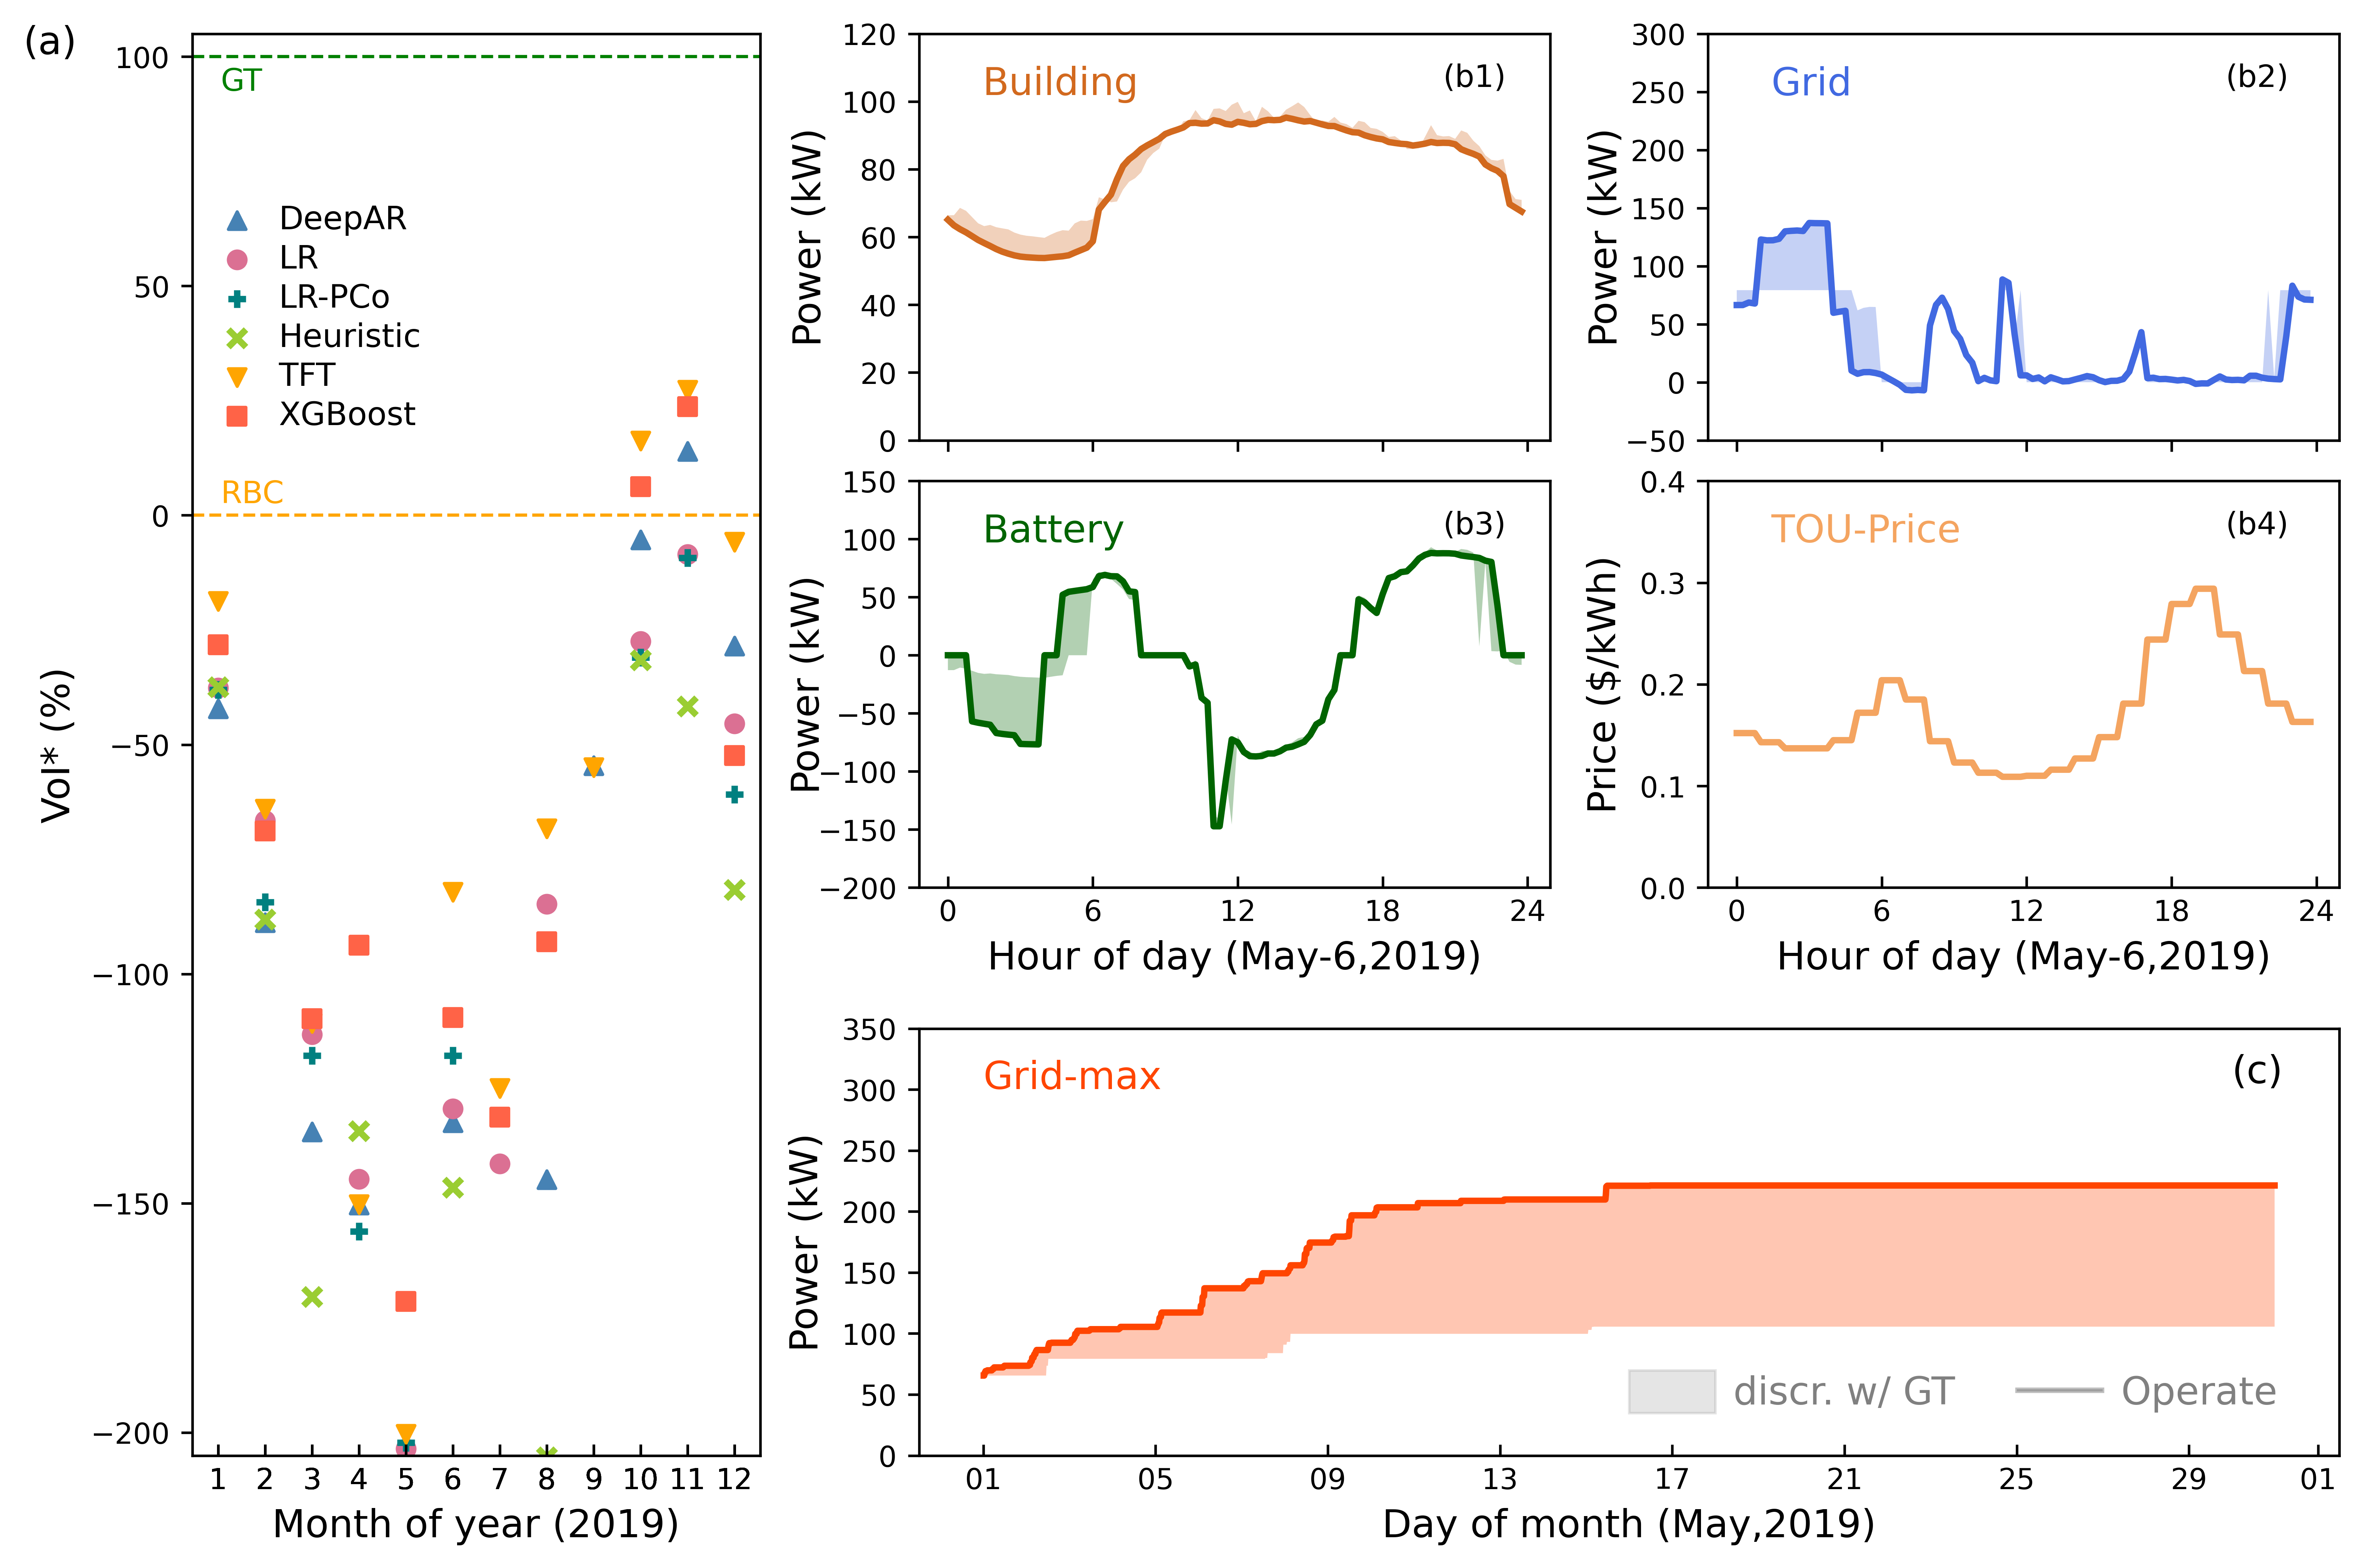

In [20]:
import matplotlib.gridspec as gridspec  # 用网格来创建子图
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.transforms as transforms

legend_fs=10
label_fs=12
ticklabel_fs=9
title_fs=14

fig = plt.figure(figsize=(12, 8))  # 创建画布
grid = gridspec.GridSpec(2, 2,width_ratios=[0.6,1.5],height_ratios=[2,1])  # 设定2行*3列的网格
grid.update(wspace =0.16, hspace = 0.22)

grid01=gridspec.GridSpecFromSubplotSpec(2,2,subplot_spec=grid[0,1],height_ratios=[1,1],width_ratios=[1,1],wspace=0.25,hspace=0.1)
#grid01.update(wspace =0.1, hspace = 0.18)

ax2 = fig.add_subplot(grid01[0, 0])  #
ax3 = fig.add_subplot(grid01[0, 1])  # 
ax4 = fig.add_subplot(grid01[1, 0])  # 
ax5 = fig.add_subplot(grid01[1, 1])  # 

ax6 = fig.add_subplot(grid[1, 1])  # 

ax1 = fig.add_subplot(grid[0:2,0])  #

'''ax1.text(-1.6,115,'(a)')
ax2.text(-2.1,17.7,'(c)')
ax3.text(-2.3,493,'(d)')
ax1.text(-1.6,-135,'(b)')
'''
label_loc=[0.75,0.92]
t0=pd.Timestamp(2019,5,6,0,0)
keys=['load_bld','p_grid','bat_p','tou_import']
axs=[ax2,ax3,ax4,ax5]
i=0
for key in keys:
    ax=axs[i]
    draw_load_curve(deepar_0dc_df, gt_0dc_df,key,ax=ax,t0=t0)
    ax.text(0.1,0.85,names[key],color=colors[key],fontsize=label_fs,
            transform=transforms.blended_transform_factory(
                ax.transAxes, ax.transAxes))
    i+=1
    
off=1.05
offy=-0.08
trans=transforms.blended_transform_factory(ax2.transAxes, ax2.transAxes)
ax2.text(-0.22+off,0.95+offy,'(b1)',color='black',fontsize=label_fs*0.8,transform=trans,zorder=200)
ax2.text(1.02+off,0.95+offy,'(b2)',color='black',fontsize=label_fs*0.8,transform=trans,zorder=200)
ax2.text(-1.42,0.95,'(a)',color='black',fontsize=label_fs,transform=trans,zorder=200)
ax2.text(-0.22+off,-0.15+offy,'(b3)',color='black',fontsize=label_fs*0.8,transform=trans,zorder=200)
ax2.text(1.02+off,-0.15+offy,'(b4)',color='black',fontsize=label_fs*0.8,transform=trans,zorder=200)
ax2.text(-0.22+off+1.25,-1.5+offy,'(c)',color='black',fontsize=label_fs,transform=trans,zorder=200)

draw_load_curve_grid_max(deepar_0dc_df, gt_0dc_df_grid_max,'latest_p_grid_max',ax=ax6)
'''text_with_ratio(names['latest_p_grid_max'], 0.83, 1.2, ax6, ha="left", va="bottom", 
                fontsize=label_fs, color=colors['latest_p_grid_max'])'''

ax2.set_ylim([0,120])
ax2.set_ylabel('Power (kW)',fontsize=label_fs, labelpad=4)
ax3.set_ylim([-50,300])
ax3.set_ylabel('Power (kW)',fontsize=label_fs,  labelpad=-0)
ax4.set_ylim([-200,150])
ax4.set_ylabel('Power (kW)',fontsize=label_fs, labelpad=-3)
ax5.set_ylim([0,0.4])
ax5.set_ylabel('Price (\$/kWh)',fontsize=label_fs, labelpad=5)

ax6.set_ylim([0,350])
ax6.set_ylabel('Power (kW)',fontsize=label_fs, labelpad=5)
ax6.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax6.tick_params(axis='x',direction="in")



ax2.set_xticks(np.arange(0, 25, 6)) 
ax2.set_xticklabels([])
ax3.set_xticks(np.arange(0, 25, 6)) 
ax3.set_xticklabels([])
ax4.tick_params(axis='x',direction="in")
ax5.tick_params(axis='x',direction="in")

#ax6.set_xticks(np.arange(0, 720, 24)) 
labels=[]
for i in range(1,31):
    labels.append(str(i))
#ax6.set_xticklabels(labels)

for ax in [ax2,ax3,ax4,ax5,ax6]:
    ax.tick_params(labelsize=ticklabel_fs)
    #ax.set_yticklabels(fontsize=ticklabel_fs)
    ...
ax4.set_xticks(np.arange(0, 25, 6)) 
ax5.set_xticks(np.arange(0, 25, 6)) 
ax4.set_xlabel('Hour of day (May-6,2019)',fontsize=label_fs)
ax5.set_xlabel('Hour of day (May-6,2019)',fontsize=label_fs)
ax6.set_xlabel('Day of month (May,2019)',fontsize=label_fs)

trans = transforms.blended_transform_factory(
    ax6.transData, ax6.transAxes)
ax6.axvspan(pd.Timestamp(2019,5,16,0,0),pd.Timestamp(2019,5,18,0,0),0.10,0.2,
            alpha=0.2,facecolor='gray',edgecolor='gray',linewidth=0.8)
ax6.text(pd.Timestamp(2019,5,18,10,0),0.12,'discr. w/ GT',color='gray',transform=trans,fontsize=label_fs)
ax6.axvspan(pd.Timestamp(2019,5,25,0,0),pd.Timestamp(2019,5,27,0,0),0.15,0.155,
            alpha=0.5,facecolor='gray',edgecolor='gray',linewidth=1)
ax6.text(pd.Timestamp(2019,5,27,10,0),0.12,'Operate',color='gray',transform=trans,fontsize=label_fs)
key='latest_p_grid_max'
ax6.text(pd.Timestamp(2019,5,1,0,0),0.86,names[key],color=colors[key],fontsize=label_fs,
            transform=trans)

########################################################################################


trans = transforms.blended_transform_factory(
    ax1.transAxes, ax1.transAxes)
ax1.text(0.05,0.96,"GT",color='green',fontsize=label_fs*0.8,
            transform=trans)
ax1.text(0.05,0.67,"RBC",color='orange',fontsize=label_fs*0.8,
            transform=trans)

path=r"L:\Coding_project\Energy_grid_new\output\experiments\Multiple_model_compare"
methods=['DeepAR_optuna','Heuristic','LR_NAIVE','LR_PCo','TFT_optuna','XGB']
to_concat=[]
for m in methods:
    fn=os.path.join(path,m+'.xlsx')
    df=pd.read_excel(fn)
    to_concat.append(df)

df_all=pd.concat(to_concat)
df_all=df_all.drop(df_all[(df_all.status!='D')].index)
df_all=df_all.drop(df_all[(df_all.ev_to_bld==0.25)].index)
df_all=df_all.drop(df_all[(df_all.price_dc==0)].index)
df_all=df_all.drop(df_all[(df_all.exe_K==1)].index)
df_dc=df_all.drop_duplicates(subset=['method','strategy','pred_model','ev_charge_rule','pred_method','month_of_year'])

df_opex_dc=pre_process(df_dc,'month_of_year','OPEX')
df_p_grid_dc=pre_process(df_dc,'month_of_year','grid_max')

df_opex_dc=df_opex_dc.drop(index=df_opex_dc[df_opex_dc.label=='RBC-GT-by_execution'].index)
df_opex_dc=df_opex_dc.drop(index=df_opex_dc[df_opex_dc.label=='MPC-GT-by_execution'].index)

plot_params={
    "subplots":{
        "0":{
            "df":df_opex_dc,           
            "key":"OPEX",
            "duration_key":"month_of_year",
            "subtitle":"",
            "limit":[-205,105],
            "relative":True,
            "show_shadow":False,
            "gradient":False,
            "gradient_params":{
                "cmap_name":"coolwarm",
                "cmap_range":[0,0.7],
                "alpha":1
                },
            "plot_arrow":False,
            "arrow_start":'MPC-Heuristic',
            "arrow_end":'MPC-Heuristic-our-method',
            },
        },
    "group_plot":[ax1],
    "labels_not_show":[],
    "relative":True,
    "fontsize":10,
    "n_subplots":1,
    "figsize":(10,8),
    "show_notes":False,
    "marker_s":100,
    "sharey":False,
    "show_line":False,
    "bbox_to_anchor":(0,0.7),
    "save_fn":None,
    "suptitle":None
}

r_opex_month_6dc=mplot_origin_valid_bar(plot_params)

########################################################################################